In [1]:
import os

DataSample = dict[str, str]

def collect_data(images_dir : str, labels_dir : str) -> list[DataSample]:
    images = sorted(os.listdir(images_dir))
    labels = sorted(os.listdir(labels_dir))
    
    data = []
    for image, label in zip(images, labels):
        data.append({"image": os.path.join(images_dir, image), "label": os.path.join(labels_dir, label)})
    
    return data

def collect_dataset(train_dir : str, val_dir : str, test_dir : str) -> dict[str, list[DataSample]]:
    dataset = {"train": [], "val": [], "test": []}
    
    dataset["train"] = collect_data(os.path.join(train_dir, "images"),
                                 os.path.join(train_dir, "labels"))
    dataset["val"] = collect_data(os.path.join(val_dir, "images"),
                                 os.path.join(val_dir, "labels"))
    dataset["test"] = collect_data(os.path.join(test_dir, "images"),
                                 os.path.join(test_dir, "labels"))
    return dataset

ROOT_DIR = "./"
DATASET_PATH = "./data/datasets/astrocyte-1.1"
# DATASET_PATH = "./data"
os.chdir(ROOT_DIR)

dataset = collect_dataset(os.path.join(DATASET_PATH, "train"),
                os.path.join(DATASET_PATH, "val"),
                os.path.join(DATASET_PATH, "test"))

In [2]:
dataset["test"]

[{'image': './data/datasets/astrocyte-1.1/test/images/0101_png.rf.eaff03e973a515def176e99b3bbbb1b2.jpg.npy',
  'label': './data/datasets/astrocyte-1.1/test/labels/0101_png.rf.eaff03e973a515def176e99b3bbbb1b2.txt.npy'},
 {'image': './data/datasets/astrocyte-1.1/test/images/0201_png.rf.80523f2f45061f74159edc048bbd21f0.jpg.npy',
  'label': './data/datasets/astrocyte-1.1/test/labels/0201_png.rf.80523f2f45061f74159edc048bbd21f0.txt.npy'},
 {'image': './data/datasets/astrocyte-1.1/test/images/0302_png.rf.c4281ccc8c53b16d7d70487e825ecf43.jpg.npy',
  'label': './data/datasets/astrocyte-1.1/test/labels/0302_png.rf.c4281ccc8c53b16d7d70487e825ecf43.txt.npy'}]

In [3]:
import numpy as np
import cv2

def load_polygons(file_path):
    polygons = []
    with open(file_path, 'r') as f:
        for line in f:
            coords = list(map(float, line.split(' ')))[1:]
            polygon = [[coords[i], coords[i+1]] for i in range(0, len(coords)-1, 2)]
            polygons.append(polygon)
    return polygons

def polygons_to_mask(polygons, image_size):
    """
    :param polygons: список полигонов, где каждый полигон - список точек [(x1,y1), ...]
    :param image_size: (width, height) выходной маски
    """
    mask = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)
    for polygon in polygons:
        pts = np.array(polygon)
        pts[:, 0] *= image_size[0]
        pts[:, 1] *= image_size[1]
        pts = pts.reshape((-1, 1, 2)).astype(np.int32)
        cv2.fillPoly(mask, [pts], color=1)
    return mask

from PIL import Image

def preprocess(image_src_path, label_src_path, image_dst_path, label_dts_path):
    image = Image.open(image_src_path) # np.load(image_src_path)
    image = np.array(image)
    print(image.shape)
    polygons = load_polygons(label_src_path)
    label = polygons_to_mask(polygons, (512, 512))
    np.save(image_dst_path, image)
    np.save(label_dts_path, label)

In [8]:
# DST_PATH = "./data/datasets/astrocyte-1.1"

# for elem in dataset["test"]:
#     print(elem["image"])
#     preprocess(elem["image"], elem["label"],
#                os.path.join(DST_PATH, "test", "images", os.path.basename(elem["image"])), 
#                os.path.join(DST_PATH, "test", "labels", os.path.basename(elem["label"])))

In [9]:
# import matplotlib.pyplot as plt 
# import numpy as np

# n = len(dataset["train"])
# fig, ax = plt.subplots(1, 5, figsize=(25, 200)); ax : list[plt.Axes]
# for i in range(n):
#     ax[i].imshow(np.load(dataset["val"][i]["label"]))

In [4]:
from monai.data.dataset import Dataset
from monai.data.dataloader import DataLoader
from monai.data import NumpyReader

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, Spacingd,
    RandFlipd, RandAffined, RandGaussianNoised, RandGaussianSmoothd,
    NormalizeIntensityd, RandAdjustContrastd
)

train_transforms = Compose([
    LoadImaged(keys=["image", "label"], reader=NumpyReader),
    EnsureTyped(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["label"]),
    EnsureChannelFirstd(keys=["image"], channel_dim=-1),
    
    # Spacing
    Spacingd(keys=["image", "label"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    RandFlipd(keys=["image", "label"], spatial_axis=0, prob=0.5),
    RandAffined(
        keys=["image", "label"], 
        prob=0.7,
        rotate_range=(0.1, 0.1, 0.1), 
        scale_range=(0.1, 0.1, 0.1), 
        translate_range=(5, 5, 5), 
        mode=("bilinear", "nearest")
    ),

    # Intensity
    # NormalizeIntensityd(keys=["image"], channel_wise=True),  # (data - mean) / std
    RandAdjustContrastd(keys=["image"], prob=0.3, gamma=(0.7, 1.5)),
    RandGaussianNoised(keys=["image"], prob=0.15, mean=0, std=0.05),
    RandGaussianSmoothd(keys=["image"], prob=0.1, sigma_x=(0.5, 1.5)),
])

val_transforms = Compose([
    LoadImaged(keys=["image", "label"], reader=NumpyReader),
    EnsureTyped(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["label"]),
    EnsureChannelFirstd(keys=["image"], channel_dim=-1),
    
    # Intensity
    # NormalizeIntensityd(keys=["image"], channel_wise=True),  # (data - mean) / std
])

train_dataset = Dataset(dataset["train"], train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=4)

val_dataset = Dataset(dataset["val"], val_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=4)

test_dataset = Dataset(dataset["test"], val_transforms)
test_dataloader = DataLoader(test_dataset)

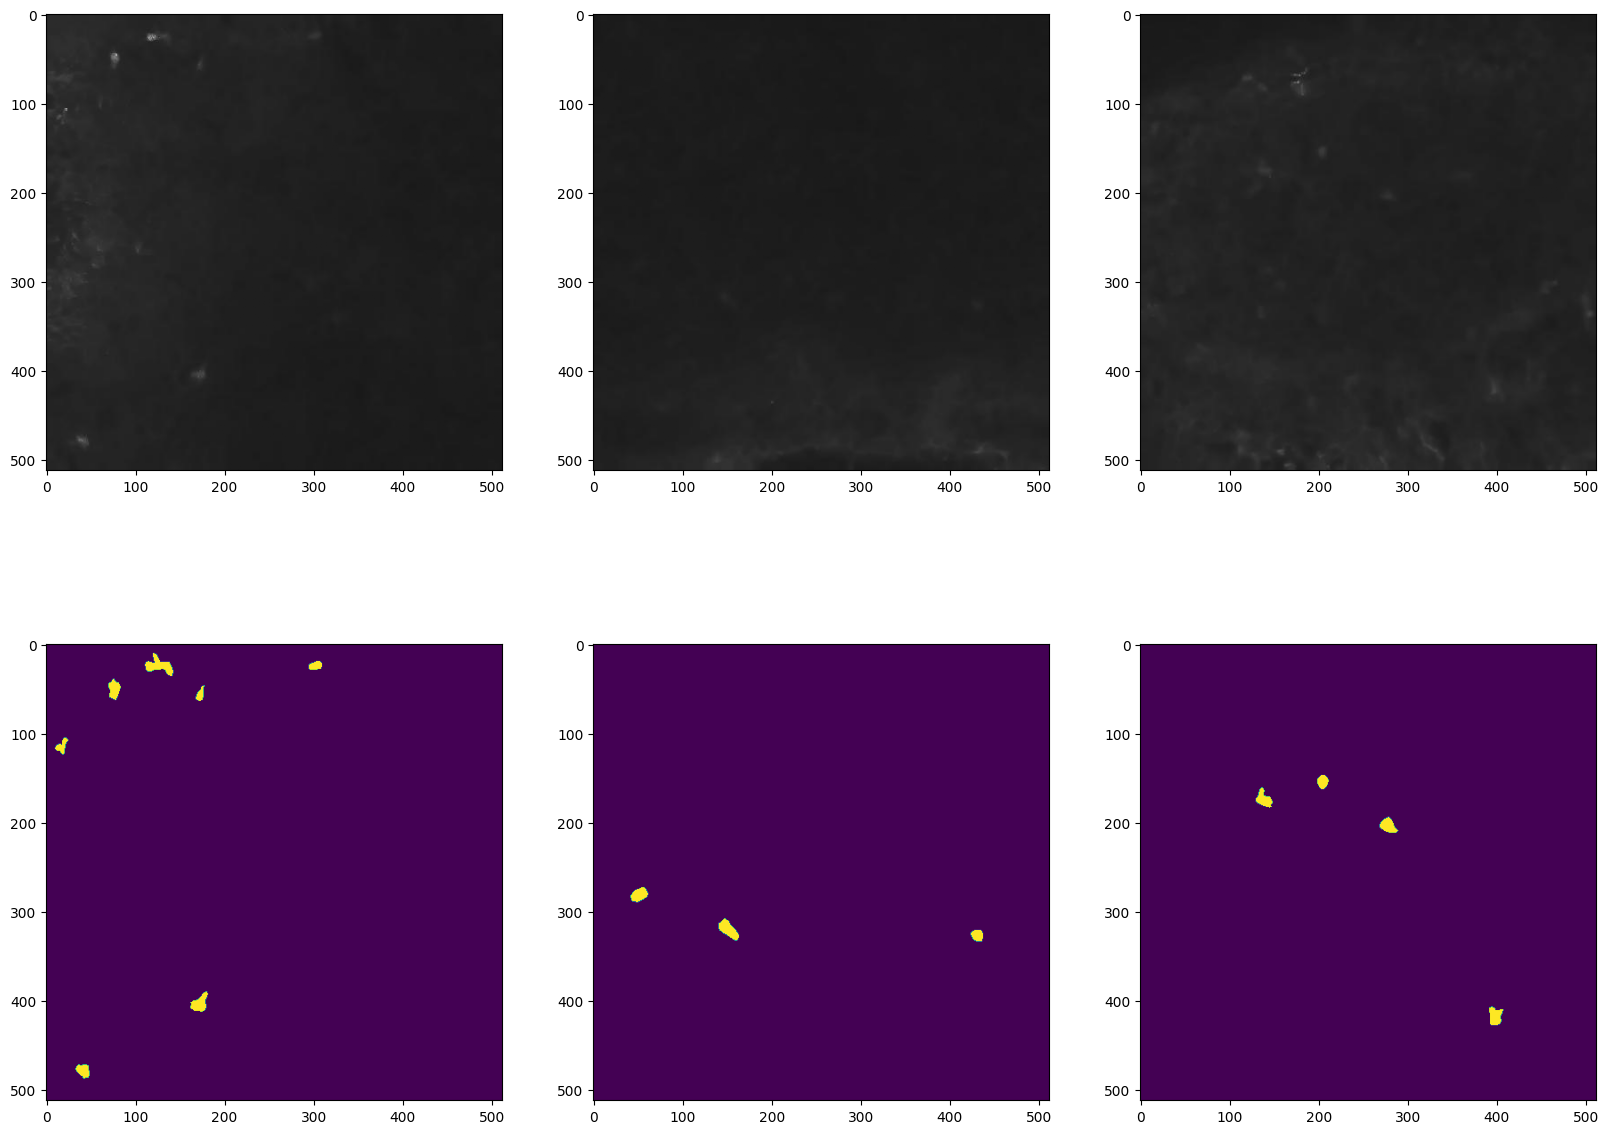

In [11]:
import torch
import matplotlib.pyplot as plt

for batch in val_dataloader:
    batch : dict[str, torch.Tensor]
    images = batch["image"]
    labels = batch["label"]
    fig, axes =plt.subplots(2, 3, figsize=(20, 15)); axes : list[plt.Axes]
    for i in range(3):
        axes[0,i].imshow(images[i].permute(1, 2, 0)/255)
        axes[1,i].imshow(labels[i].permute(1, 2, 0)/255)

In [6]:
import torch
from monai.networks.nets import AttentionUnet
from monai.losses import DiceLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AttentionUnet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(64, 128, 256, 512, 1024),
    strides=(2, 2, 2, 2),
)
model = model.to(device)

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
class Dice():
    def __init__ (self, smooth=1e-6):
        self.smooth = smooth
        self.by_classes = torch.tensor([])
        
    def __call__(self, outputs : torch.Tensor, targets : torch.Tensor):
        self.intersection = (outputs & targets).sum((2, 3))
        self.union = (outputs | targets).sum((2, 3))
        self.by_classes = (2 * self.intersection) / (self.union + self.intersection + self.smooth)
        return self.by_classes.mean(dim=0)
    
    def mean(self):
        return self.by_classes.mean(dim=1).mean(dim=0)

In [6]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(os.path.join("runs", "v.04"))

def write_logs(
    writer : SummaryWriter,
    train_loss : float,
    train_dice : float,
    val_loss : float,
    val_dice : float,
    step : int,
):
    # train
    writer.add_scalar("train/loss", train_loss, step)
    writer.add_scalar("train/mean_dice", train_dice, step)
    
    # validation
    writer.add_scalar("val/loss", val_loss, step)
    writer.add_scalar("val/mean_dice", val_dice, step)

    # compare
    writer.add_scalars("compare/loss", {"train": train_loss, "val": val_loss}, step)
    writer.add_scalars("compare/mean_dice", {"train": train_dice, "val": val_dice}, step)

In [7]:
from torchvision.utils import make_grid
def make_grid_image(images : list[torch.Tensor]):
    for i in range(len(images)):
        images[i] = torch.Tensor(images[i])[0].cpu()
        if images[i].size(0) == 1:
            images[i] = images[i].repeat(3, 1, 1)

    return make_grid(images)

In [8]:
from tqdm import tqdm

epochs = 100
dice = Dice()
best_dice = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_mean_dice = 0
    for batch in tqdm(train_dataloader):
        batch  : dict[str, torch.Tensor]
        inputs, targets = batch["image"].to(device), batch["label"].to(device)
        
        outputs = model(inputs); outputs : torch.Tensor
        loss = loss_function(outputs, targets); loss : torch.Tensor
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        
        mask = (torch.sigmoid(outputs) > 0.5).int()
        targets = targets.int()
        
        dice(mask, targets); mean_dice = dice.mean()
        train_mean_dice += mean_dice
    
    val_loss = 0
    val_mean_dice = 0
    with torch.no_grad():
        model.eval()
        for batch in tqdm(val_dataloader):
            batch : dict[str, torch.Tensor]
            inputs, targets = batch["image"].to(device), batch["label"].to(device)

            outputs = model(inputs); outputs : torch.Tensor
            loss = loss_function(outputs, targets); loss : torch.Tensor
            val_loss += loss.item()
            
            mask = (torch.sigmoid(outputs) > 0.8).int()
            targets = targets.int()
            
            dice(mask, targets); mean_dice = dice.mean()
            val_mean_dice += mean_dice
    
            last_batch = batch
            last_batch["pred"] = outputs

    train_loss /= len(train_dataloader)
    train_mean_dice /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mean_dice /= len(val_dataloader)
    print(f"{epoch+1}/{epochs}: train_loss={train_loss:.5}, train_mean_dice={train_mean_dice:.5}")
    print(f"{epoch+1}/{epochs}: val_loss={val_loss:.5}, val_mean_dice={val_mean_dice:.5}")
    
    if best_dice < val_mean_dice:
        best_dice = val_mean_dice
        torch.save(model.state_dict(), os.path.join("checkpoints", "best.pth"))
    else:
        print(f"No improvement in val mean dice, skip saving checkpoint best_dice={best_dice:.5}")
    write_logs(writer, train_loss, train_mean_dice, val_loss, val_mean_dice, epoch+1)
    grid_image = make_grid_image([inputs/255, targets, outputs])
    writer.add_image("val/image_grid", grid_image, epoch+1)

100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


1/100: train_loss=0.98031, train_mean_dice=0.022432
1/100: val_loss=0.97404, val_mean_dice=0.20935


100%|██████████| 1/1 [00:00<00:00, 10.76it/s]


2/100: train_loss=0.96943, train_mean_dice=0.078036
2/100: val_loss=0.96, val_mean_dice=0.26925


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


3/100: train_loss=0.96271, train_mean_dice=0.17297
3/100: val_loss=0.95106, val_mean_dice=0.28377


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


4/100: train_loss=0.95933, train_mean_dice=0.16991
4/100: val_loss=0.9492, val_mean_dice=0.31995


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


5/100: train_loss=0.9572, train_mean_dice=0.20408
5/100: val_loss=0.94774, val_mean_dice=0.27968
No improvement in val mean dice, skip saving checkpoint best_dice=0.31995


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


6/100: train_loss=0.95487, train_mean_dice=0.20945
6/100: val_loss=0.94259, val_mean_dice=0.33273


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


7/100: train_loss=0.95244, train_mean_dice=0.22162
7/100: val_loss=0.94212, val_mean_dice=0.36585


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


8/100: train_loss=0.95103, train_mean_dice=0.23421
8/100: val_loss=0.93648, val_mean_dice=0.34844
No improvement in val mean dice, skip saving checkpoint best_dice=0.36585


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


9/100: train_loss=0.94729, train_mean_dice=0.25764
9/100: val_loss=0.93554, val_mean_dice=0.39528


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


10/100: train_loss=0.94428, train_mean_dice=0.2861
10/100: val_loss=0.93232, val_mean_dice=0.35421
No improvement in val mean dice, skip saving checkpoint best_dice=0.39528


100%|██████████| 1/1 [00:00<00:00, 10.30it/s]


11/100: train_loss=0.94317, train_mean_dice=0.22981
11/100: val_loss=0.93079, val_mean_dice=0.36151
No improvement in val mean dice, skip saving checkpoint best_dice=0.39528


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


12/100: train_loss=0.9413, train_mean_dice=0.27273
12/100: val_loss=0.93052, val_mean_dice=0.40525


100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


13/100: train_loss=0.93649, train_mean_dice=0.30818
13/100: val_loss=0.9268, val_mean_dice=0.47741


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


14/100: train_loss=0.93391, train_mean_dice=0.30673
14/100: val_loss=0.92021, val_mean_dice=0.38218
No improvement in val mean dice, skip saving checkpoint best_dice=0.47741


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


15/100: train_loss=0.92849, train_mean_dice=0.32837
15/100: val_loss=0.91571, val_mean_dice=0.45037
No improvement in val mean dice, skip saving checkpoint best_dice=0.47741


100%|██████████| 1/1 [00:00<00:00, 10.49it/s]


16/100: train_loss=0.92651, train_mean_dice=0.33757
16/100: val_loss=0.91005, val_mean_dice=0.45282
No improvement in val mean dice, skip saving checkpoint best_dice=0.47741


100%|██████████| 1/1 [00:00<00:00, 10.18it/s]


17/100: train_loss=0.92424, train_mean_dice=0.3378
17/100: val_loss=0.90712, val_mean_dice=0.41524
No improvement in val mean dice, skip saving checkpoint best_dice=0.47741


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


18/100: train_loss=0.91937, train_mean_dice=0.35324
18/100: val_loss=0.90211, val_mean_dice=0.41427
No improvement in val mean dice, skip saving checkpoint best_dice=0.47741


100%|██████████| 1/1 [00:00<00:00, 10.80it/s]


19/100: train_loss=0.91601, train_mean_dice=0.35007
19/100: val_loss=0.89703, val_mean_dice=0.44586
No improvement in val mean dice, skip saving checkpoint best_dice=0.47741


100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


20/100: train_loss=0.91104, train_mean_dice=0.38168
20/100: val_loss=0.89182, val_mean_dice=0.4584
No improvement in val mean dice, skip saving checkpoint best_dice=0.47741


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


21/100: train_loss=0.90442, train_mean_dice=0.40015
21/100: val_loss=0.88684, val_mean_dice=0.46158
No improvement in val mean dice, skip saving checkpoint best_dice=0.47741


100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


22/100: train_loss=0.89898, train_mean_dice=0.40686
22/100: val_loss=0.88265, val_mean_dice=0.50156


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


23/100: train_loss=0.89061, train_mean_dice=0.43434
23/100: val_loss=0.87372, val_mean_dice=0.47743
No improvement in val mean dice, skip saving checkpoint best_dice=0.50156


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


24/100: train_loss=0.88863, train_mean_dice=0.43518
24/100: val_loss=0.86413, val_mean_dice=0.50562


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


25/100: train_loss=0.88133, train_mean_dice=0.43969
25/100: val_loss=0.8676, val_mean_dice=0.49204
No improvement in val mean dice, skip saving checkpoint best_dice=0.50562


100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


26/100: train_loss=0.87177, train_mean_dice=0.44864
26/100: val_loss=0.84855, val_mean_dice=0.5217


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


27/100: train_loss=0.86399, train_mean_dice=0.4975
27/100: val_loss=0.84178, val_mean_dice=0.47001
No improvement in val mean dice, skip saving checkpoint best_dice=0.5217


100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


28/100: train_loss=0.85884, train_mean_dice=0.46621
28/100: val_loss=0.83786, val_mean_dice=0.45434
No improvement in val mean dice, skip saving checkpoint best_dice=0.5217


100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


29/100: train_loss=0.84742, train_mean_dice=0.49517
29/100: val_loss=0.82663, val_mean_dice=0.46394
No improvement in val mean dice, skip saving checkpoint best_dice=0.5217


100%|██████████| 1/1 [00:00<00:00, 10.57it/s]


30/100: train_loss=0.84315, train_mean_dice=0.48996
30/100: val_loss=0.81991, val_mean_dice=0.49834
No improvement in val mean dice, skip saving checkpoint best_dice=0.5217


100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


31/100: train_loss=0.83485, train_mean_dice=0.50062
31/100: val_loss=0.80048, val_mean_dice=0.5762


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


32/100: train_loss=0.82169, train_mean_dice=0.52565
32/100: val_loss=0.79134, val_mean_dice=0.51475
No improvement in val mean dice, skip saving checkpoint best_dice=0.5762


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


33/100: train_loss=0.81148, train_mean_dice=0.53163
33/100: val_loss=0.76793, val_mean_dice=0.56704
No improvement in val mean dice, skip saving checkpoint best_dice=0.5762


100%|██████████| 1/1 [00:00<00:00, 10.61it/s]


34/100: train_loss=0.7988, train_mean_dice=0.52006
34/100: val_loss=0.76762, val_mean_dice=0.53451
No improvement in val mean dice, skip saving checkpoint best_dice=0.5762


100%|██████████| 1/1 [00:00<00:00, 10.24it/s]


35/100: train_loss=0.8003, train_mean_dice=0.49237
35/100: val_loss=0.76694, val_mean_dice=0.50945
No improvement in val mean dice, skip saving checkpoint best_dice=0.5762


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


36/100: train_loss=0.78038, train_mean_dice=0.53148
36/100: val_loss=0.75187, val_mean_dice=0.50943
No improvement in val mean dice, skip saving checkpoint best_dice=0.5762


100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


37/100: train_loss=0.77948, train_mean_dice=0.49464
37/100: val_loss=0.7555, val_mean_dice=0.52211
No improvement in val mean dice, skip saving checkpoint best_dice=0.5762


100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


38/100: train_loss=0.75873, train_mean_dice=0.53518
38/100: val_loss=0.74322, val_mean_dice=0.52846
No improvement in val mean dice, skip saving checkpoint best_dice=0.5762


100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


39/100: train_loss=0.73617, train_mean_dice=0.575
39/100: val_loss=0.69397, val_mean_dice=0.57443
No improvement in val mean dice, skip saving checkpoint best_dice=0.5762


100%|██████████| 1/1 [00:00<00:00, 10.48it/s]


40/100: train_loss=0.72476, train_mean_dice=0.59291
40/100: val_loss=0.68508, val_mean_dice=0.57583
No improvement in val mean dice, skip saving checkpoint best_dice=0.5762


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


41/100: train_loss=0.71003, train_mean_dice=0.5987
41/100: val_loss=0.67244, val_mean_dice=0.60153


100%|██████████| 1/1 [00:00<00:00, 10.74it/s]


42/100: train_loss=0.69266, train_mean_dice=0.60202
42/100: val_loss=0.66424, val_mean_dice=0.59315
No improvement in val mean dice, skip saving checkpoint best_dice=0.60153


100%|██████████| 1/1 [00:00<00:00, 10.65it/s]


43/100: train_loss=0.6672, train_mean_dice=0.62056
43/100: val_loss=0.66352, val_mean_dice=0.58132
No improvement in val mean dice, skip saving checkpoint best_dice=0.60153


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


44/100: train_loss=0.65849, train_mean_dice=0.60263
44/100: val_loss=0.62026, val_mean_dice=0.60765


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


45/100: train_loss=0.62838, train_mean_dice=0.64214
45/100: val_loss=0.59636, val_mean_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


46/100: train_loss=0.61624, train_mean_dice=0.65493
46/100: val_loss=0.6424, val_mean_dice=0.48983
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


47/100: train_loss=0.60009, train_mean_dice=0.66042
47/100: val_loss=0.59099, val_mean_dice=0.62206
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.91it/s]


48/100: train_loss=0.58087, train_mean_dice=0.66628
48/100: val_loss=0.5611, val_mean_dice=0.60979
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


49/100: train_loss=0.56502, train_mean_dice=0.66139
49/100: val_loss=0.58493, val_mean_dice=0.54102
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


50/100: train_loss=0.55026, train_mean_dice=0.66696
50/100: val_loss=0.53789, val_mean_dice=0.58841
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


51/100: train_loss=0.53326, train_mean_dice=0.68095
51/100: val_loss=0.53383, val_mean_dice=0.57055
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


52/100: train_loss=0.52783, train_mean_dice=0.66042
52/100: val_loss=0.51012, val_mean_dice=0.62415
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


53/100: train_loss=0.5231, train_mean_dice=0.64845
53/100: val_loss=0.53627, val_mean_dice=0.56293
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


54/100: train_loss=0.51317, train_mean_dice=0.64351
54/100: val_loss=0.53996, val_mean_dice=0.59013
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


55/100: train_loss=0.51028, train_mean_dice=0.63962
55/100: val_loss=0.50989, val_mean_dice=0.5627
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


56/100: train_loss=0.52931, train_mean_dice=0.59087
56/100: val_loss=0.55853, val_mean_dice=0.49045
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


57/100: train_loss=0.47767, train_mean_dice=0.66043
57/100: val_loss=0.50733, val_mean_dice=0.543
No improvement in val mean dice, skip saving checkpoint best_dice=0.62685


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


58/100: train_loss=0.45575, train_mean_dice=0.68273
58/100: val_loss=0.44227, val_mean_dice=0.63603


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


59/100: train_loss=0.44929, train_mean_dice=0.6769
59/100: val_loss=0.44602, val_mean_dice=0.62434
No improvement in val mean dice, skip saving checkpoint best_dice=0.63603


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


60/100: train_loss=0.42472, train_mean_dice=0.7002
60/100: val_loss=0.43742, val_mean_dice=0.64648


100%|██████████| 1/1 [00:00<00:00, 10.83it/s]


61/100: train_loss=0.40612, train_mean_dice=0.71866
61/100: val_loss=0.45612, val_mean_dice=0.58965
No improvement in val mean dice, skip saving checkpoint best_dice=0.64648


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


62/100: train_loss=0.39588, train_mean_dice=0.71834
62/100: val_loss=0.43155, val_mean_dice=0.60538
No improvement in val mean dice, skip saving checkpoint best_dice=0.64648


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


63/100: train_loss=0.38872, train_mean_dice=0.71164
63/100: val_loss=0.40518, val_mean_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.28it/s]


64/100: train_loss=0.38181, train_mean_dice=0.71696
64/100: val_loss=0.52888, val_mean_dice=0.48719
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


65/100: train_loss=0.37537, train_mean_dice=0.7146
65/100: val_loss=0.4066, val_mean_dice=0.61172
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.59it/s]


66/100: train_loss=0.35996, train_mean_dice=0.72612
66/100: val_loss=0.52254, val_mean_dice=0.45578
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


67/100: train_loss=0.37401, train_mean_dice=0.69835
67/100: val_loss=0.45033, val_mean_dice=0.55319
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


68/100: train_loss=0.36813, train_mean_dice=0.70141
68/100: val_loss=0.41389, val_mean_dice=0.588
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.66it/s]


69/100: train_loss=0.34872, train_mean_dice=0.71517
69/100: val_loss=0.43191, val_mean_dice=0.54819
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


70/100: train_loss=0.32663, train_mean_dice=0.74527
70/100: val_loss=0.41085, val_mean_dice=0.58194
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.67it/s]


71/100: train_loss=0.31866, train_mean_dice=0.74731
71/100: val_loss=0.35328, val_mean_dice=0.64242
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.63it/s]


72/100: train_loss=0.29254, train_mean_dice=0.77344
72/100: val_loss=0.3887, val_mean_dice=0.60105
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.60it/s]


73/100: train_loss=0.29232, train_mean_dice=0.76605
73/100: val_loss=0.36731, val_mean_dice=0.6309
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


74/100: train_loss=0.28958, train_mean_dice=0.76736
74/100: val_loss=0.39517, val_mean_dice=0.60732
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


75/100: train_loss=0.29134, train_mean_dice=0.75984
75/100: val_loss=0.36374, val_mean_dice=0.59089
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.50it/s]


76/100: train_loss=0.28965, train_mean_dice=0.75074
76/100: val_loss=0.35966, val_mean_dice=0.6386
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


77/100: train_loss=0.27746, train_mean_dice=0.7631
77/100: val_loss=0.37261, val_mean_dice=0.57124
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


78/100: train_loss=0.25585, train_mean_dice=0.78788
78/100: val_loss=0.40751, val_mean_dice=0.55108
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.44it/s]


79/100: train_loss=0.25879, train_mean_dice=0.78319
79/100: val_loss=0.41339, val_mean_dice=0.56294
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


80/100: train_loss=0.25122, train_mean_dice=0.7862
80/100: val_loss=0.41832, val_mean_dice=0.55981
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


81/100: train_loss=0.25946, train_mean_dice=0.76848
81/100: val_loss=0.39991, val_mean_dice=0.5384
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


82/100: train_loss=0.25539, train_mean_dice=0.77287
82/100: val_loss=0.38973, val_mean_dice=0.58718
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


83/100: train_loss=0.26458, train_mean_dice=0.75766
83/100: val_loss=0.41796, val_mean_dice=0.55643
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


84/100: train_loss=0.28087, train_mean_dice=0.73727
84/100: val_loss=0.43712, val_mean_dice=0.45263
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.72it/s]


85/100: train_loss=0.27728, train_mean_dice=0.73505
85/100: val_loss=0.40312, val_mean_dice=0.49876
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.27it/s]


86/100: train_loss=0.24674, train_mean_dice=0.76928
86/100: val_loss=0.43057, val_mean_dice=0.46486
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00,  9.84it/s]


87/100: train_loss=0.24783, train_mean_dice=0.7691
87/100: val_loss=0.4008, val_mean_dice=0.53648
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.14it/s]


88/100: train_loss=0.23849, train_mean_dice=0.77763
88/100: val_loss=0.42157, val_mean_dice=0.47408
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.38it/s]


89/100: train_loss=0.22501, train_mean_dice=0.79285
89/100: val_loss=0.42159, val_mean_dice=0.48676
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.55it/s]


90/100: train_loss=0.20925, train_mean_dice=0.80858
90/100: val_loss=0.40732, val_mean_dice=0.5375
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


91/100: train_loss=0.22565, train_mean_dice=0.78796
91/100: val_loss=0.34916, val_mean_dice=0.60071
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


92/100: train_loss=0.22431, train_mean_dice=0.78537
92/100: val_loss=0.34112, val_mean_dice=0.60393
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


93/100: train_loss=0.23136, train_mean_dice=0.77217
93/100: val_loss=0.38985, val_mean_dice=0.57852
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.31it/s]


94/100: train_loss=0.22821, train_mean_dice=0.77586
94/100: val_loss=0.39671, val_mean_dice=0.52593
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


95/100: train_loss=0.2199, train_mean_dice=0.78504
95/100: val_loss=0.38825, val_mean_dice=0.52318
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


96/100: train_loss=0.1997, train_mean_dice=0.80749
96/100: val_loss=0.41101, val_mean_dice=0.51884
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


97/100: train_loss=0.20015, train_mean_dice=0.80584
97/100: val_loss=0.3682, val_mean_dice=0.57601
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00,  9.84it/s]


98/100: train_loss=0.20197, train_mean_dice=0.80104
98/100: val_loss=0.41167, val_mean_dice=0.4582
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


99/100: train_loss=0.20451, train_mean_dice=0.79461
99/100: val_loss=0.41763, val_mean_dice=0.50866
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]

100/100: train_loss=0.1979, train_mean_dice=0.80493
100/100: val_loss=0.39306, val_mean_dice=0.53452
No improvement in val mean dice, skip saving checkpoint best_dice=0.65208


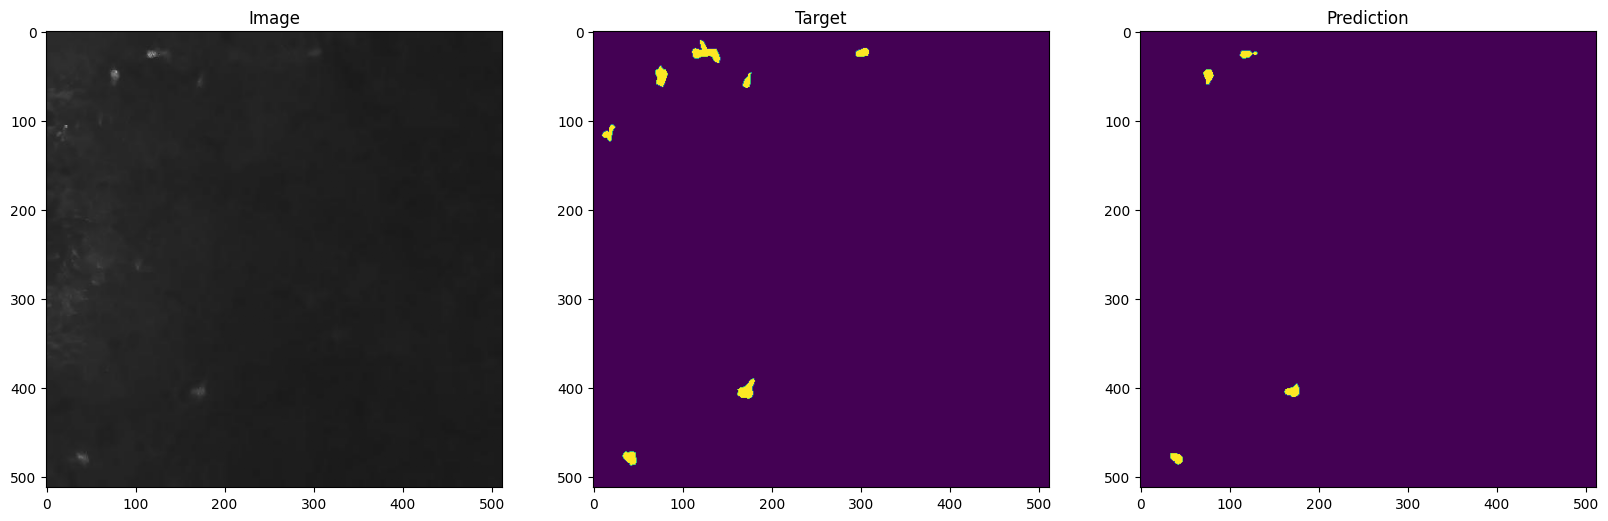

In [9]:
import matplotlib.pyplot as plt
import skimage
import numpy as np

def show_result(inputs : torch.Tensor, targets : torch.Tensor, outputs : torch.Tensor):
    inputs = inputs.clone().cpu()
    targets = targets.clone().cpu()
    outputs = outputs.clone().cpu()
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 20))
    ax[0].imshow(np.array(inputs)/255)
    ax[1].imshow(targets)
    ax[2].imshow(outputs)
    ax[0].set_title("Image")
    ax[1].set_title("Target")
    ax[2].set_title("Prediction")
    plt.show()

targets = targets.squeeze(dim=1)
mask = mask.squeeze(dim=1)
ind = 0
show_result(inputs[ind].permute(1, 2, 0), targets[ind], mask[ind])

In [8]:
checkpoint = os.path.join("checkpoints", "best.pth")
model.load_state_dict(torch.load(checkpoint, weights_only=True))

<All keys matched successfully>

In [83]:
from tqdm import tqdm

dice = Dice()
inputs_list = []
targets_list = []
preds_list = []

with torch.no_grad():
    model.eval()    
    for batch in tqdm(train_dataloader):
        inputs, targets = batch["image"].to(device), batch["label"].to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        
        mask = (torch.sigmoid(outputs) > 0.9).int()
        targets = targets.int()
        
        dice(mask, targets); mean_dice = dice.mean()
        # test_mean_dice += mean_dice
        
        print(f": test_mean_dice={mean_dice:.5}")
        inputs_list.append(inputs); targets_list.append(targets); preds_list.append(mask)
        # test_mean_dice /= len(train_dataloader)

  6%|▌         | 1/18 [00:00<00:05,  2.99it/s]

: test_mean_dice=0.61364


 11%|█         | 2/18 [00:00<00:04,  3.77it/s]

: test_mean_dice=0.66559


 17%|█▋        | 3/18 [00:00<00:03,  3.85it/s]

: test_mean_dice=0.45545


 28%|██▊       | 5/18 [00:01<00:02,  4.55it/s]

: test_mean_dice=0.61731
: test_mean_dice=0.66702


 33%|███▎      | 6/18 [00:01<00:02,  4.54it/s]

: test_mean_dice=0.76538


 39%|███▉      | 7/18 [00:01<00:02,  4.56it/s]

: test_mean_dice=0.54522


 44%|████▍     | 8/18 [00:01<00:02,  4.49it/s]

: test_mean_dice=0.61042


 50%|█████     | 9/18 [00:02<00:01,  4.55it/s]

: test_mean_dice=0.56341


 56%|█████▌    | 10/18 [00:02<00:01,  4.66it/s]

: test_mean_dice=0.72902


 61%|██████    | 11/18 [00:02<00:01,  4.45it/s]

: test_mean_dice=0.83835


 67%|██████▋   | 12/18 [00:02<00:01,  4.14it/s]

: test_mean_dice=0.82729


 72%|███████▏  | 13/18 [00:03<00:01,  4.03it/s]

: test_mean_dice=0.64261


 78%|███████▊  | 14/18 [00:03<00:00,  4.12it/s]

: test_mean_dice=0.7623


 83%|████████▎ | 15/18 [00:03<00:00,  4.21it/s]

: test_mean_dice=0.69913


 89%|████████▉ | 16/18 [00:03<00:00,  4.39it/s]

: test_mean_dice=0.73781


100%|██████████| 18/18 [00:04<00:00,  4.46it/s]

: test_mean_dice=0.74881
: test_mean_dice=0.77009


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00028170532..0.9593498].


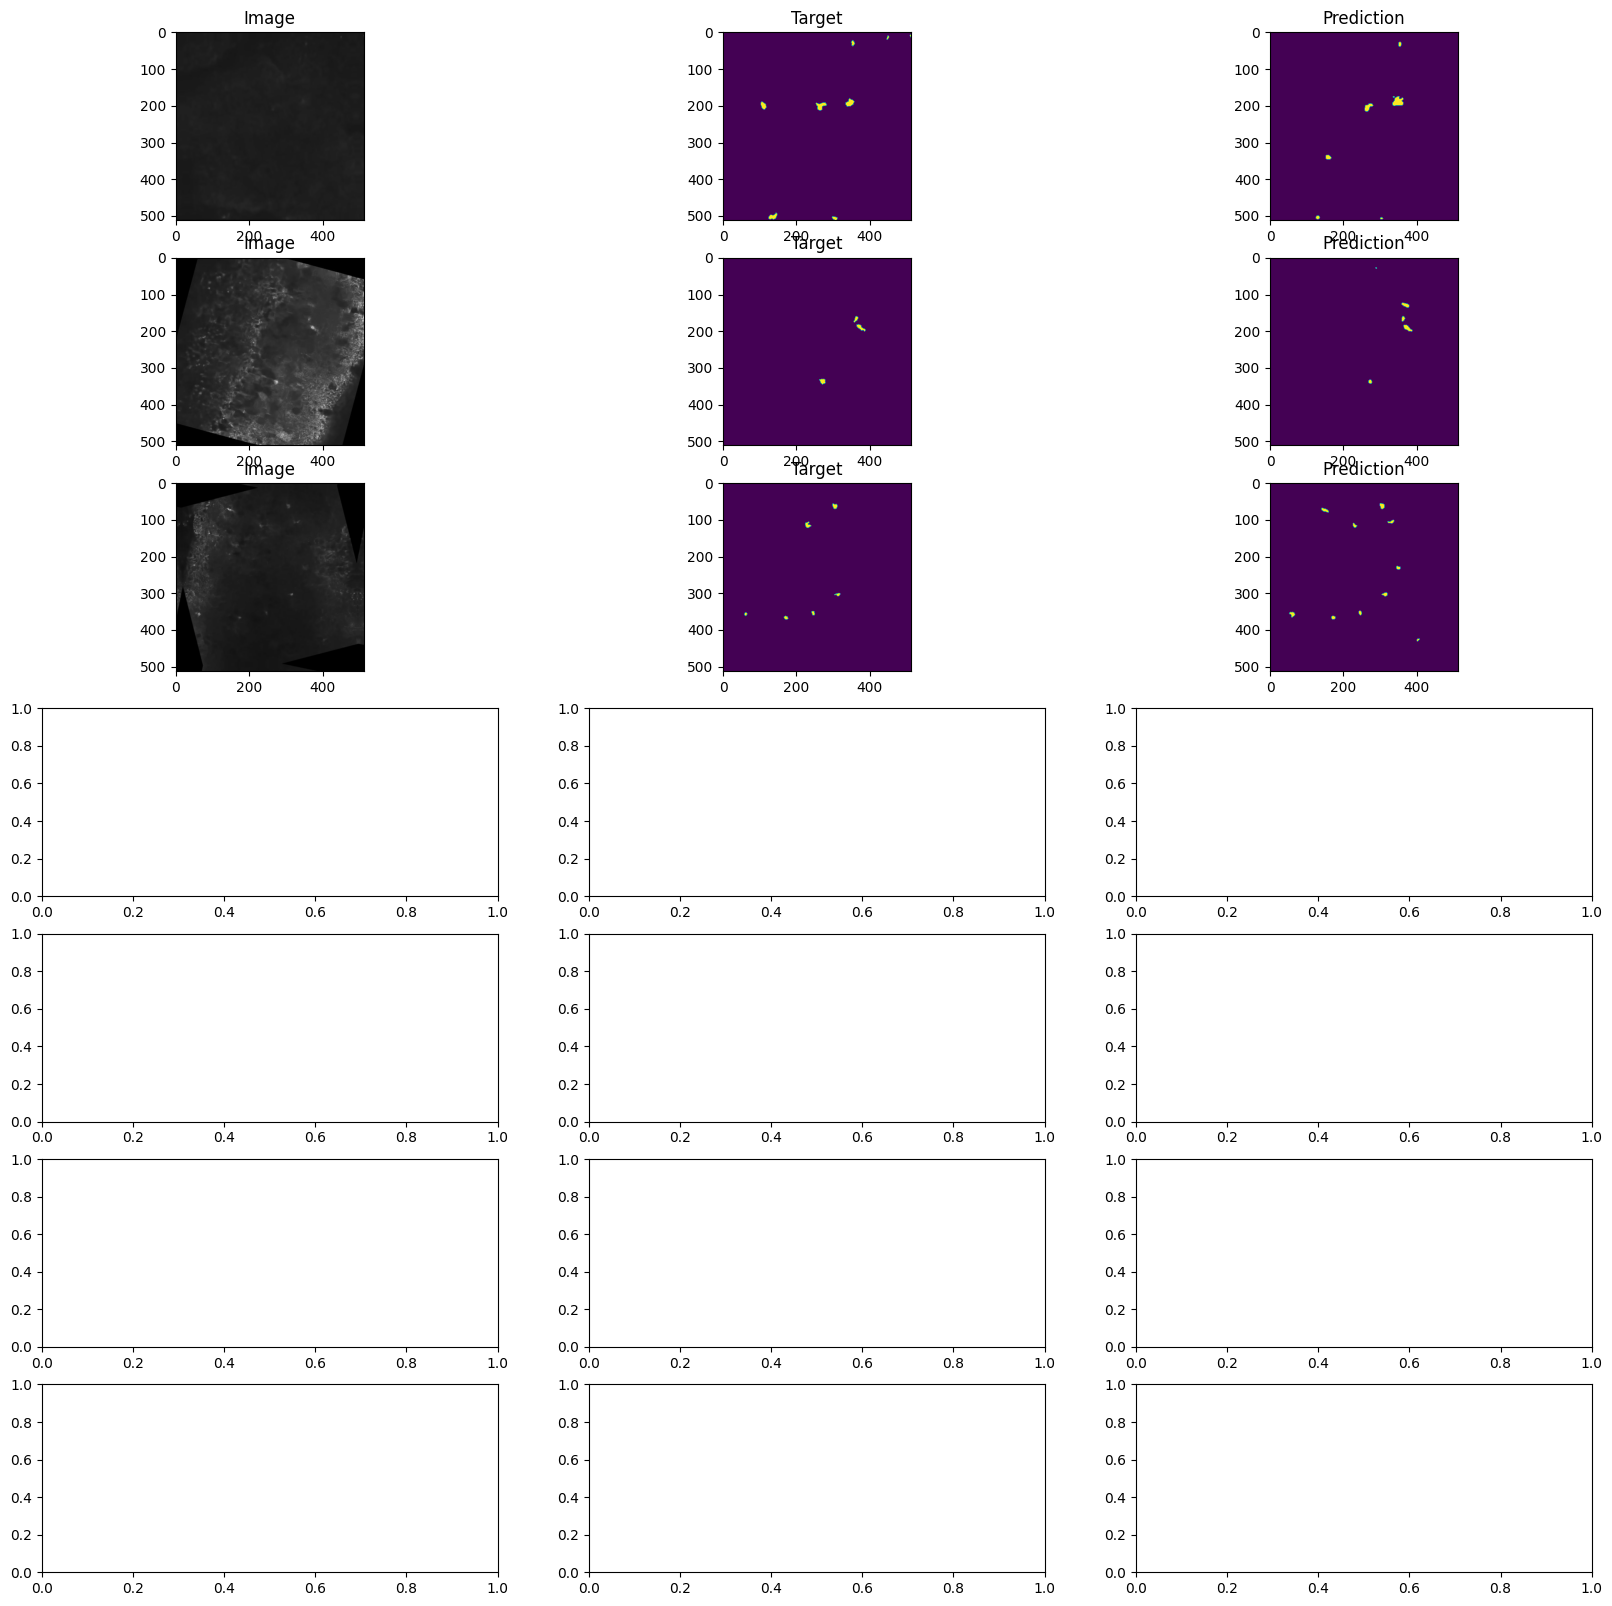

In [85]:
import matplotlib.pyplot as plt
import skimage

def show_result(inputs_list : torch.Tensor, targets_list : torch.Tensor, outputs_list : torch.Tensor):
    fig, ax = plt.subplots(7, 3, figsize=(20, 20)); ax : list[plt.Axes]
    for i in range(3):
        inputs = inputs_list[i][0].permute(1, 2, 0).clone().cpu()
        targets = targets_list[i][0].squeeze(dim=0).clone().cpu()
        outputs = outputs_list[i][0].squeeze(dim=0).clone().cpu()
        ax[i, 0].imshow(inputs/255)
        ax[i, 1].imshow(targets)
        ax[i, 2].imshow(outputs)
        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Target")
        ax[i, 2].set_title("Prediction")
        
    
    # plt.show()

show_result(inputs_list, targets_list, preds_list)

In [55]:
dataset['test']

[{'image': './data/datasets/astrocyte-1.1/test/images/0101_png.rf.eaff03e973a515def176e99b3bbbb1b2.jpg.npy',
  'label': './data/datasets/astrocyte-1.1/test/labels/0101_png.rf.eaff03e973a515def176e99b3bbbb1b2.txt.npy'},
 {'image': './data/datasets/astrocyte-1.1/test/images/0201_png.rf.80523f2f45061f74159edc048bbd21f0.jpg.npy',
  'label': './data/datasets/astrocyte-1.1/test/labels/0201_png.rf.80523f2f45061f74159edc048bbd21f0.txt.npy'},
 {'image': './data/datasets/astrocyte-1.1/test/images/0302_png.rf.c4281ccc8c53b16d7d70487e825ecf43.jpg.npy',
  'label': './data/datasets/astrocyte-1.1/test/labels/0302_png.rf.c4281ccc8c53b16d7d70487e825ecf43.txt.npy'}]

In [ ]:
inputs_list[7:10][0]

torch.Size([4, 3, 512, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00014615932..0.23930044].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00022777225..1.0].


(512, 512)
(512, 512)
(512, 512)
(512, 512)


IndexError: index 3 is out of bounds for axis 0 with size 3

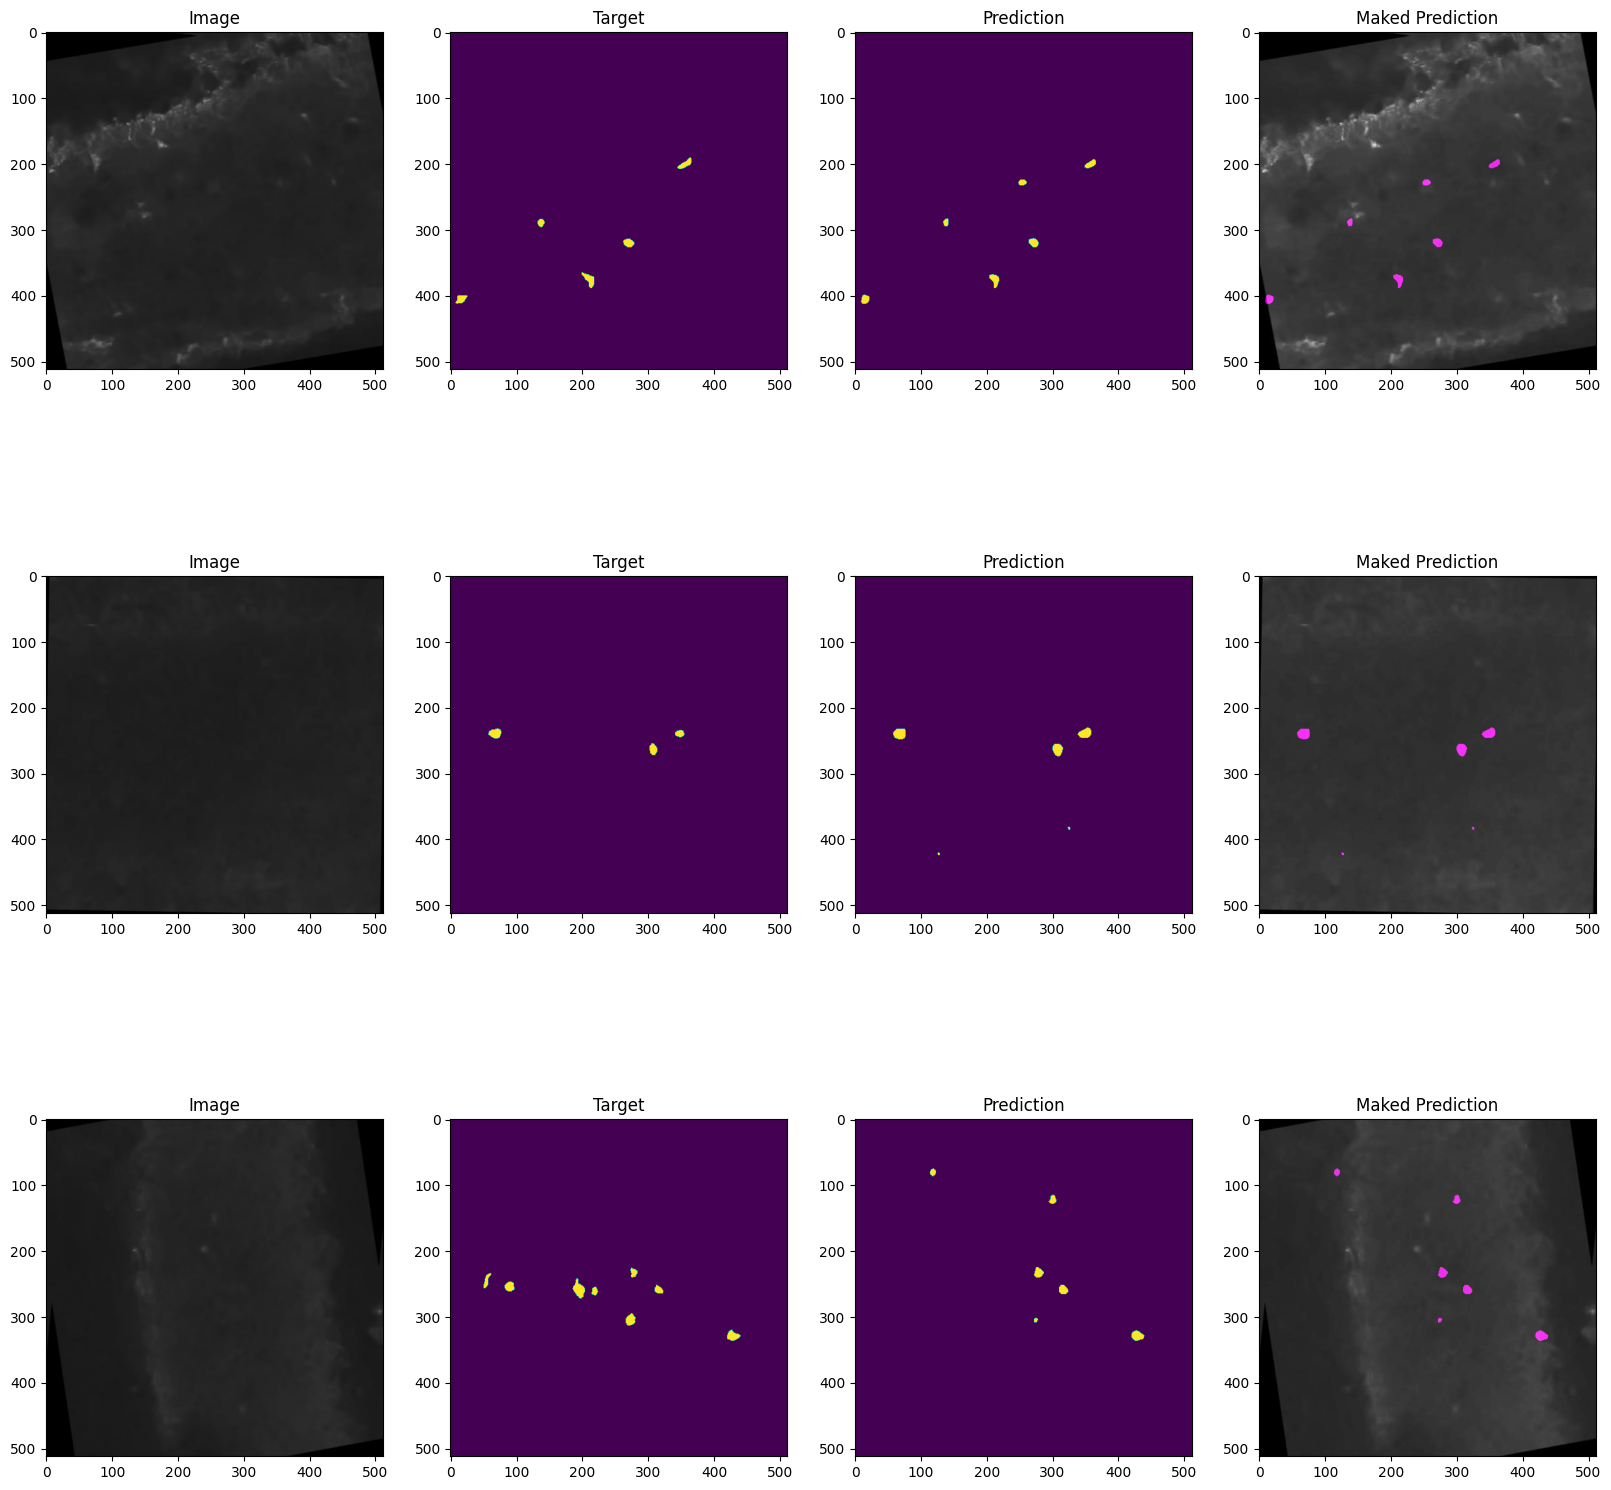

In [114]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

def apply_mask_and_show(inputs_list : torch.Tensor, targets_list : torch.Tensor, outputs_list : torch.Tensor, alpha=0.5):
    fig, ax = plt.subplots(3, 4, figsize=(20, 20)); ax : list[plt.Axes]
    for i in range(len(inputs_list)):
        inputs = inputs_list[i][3] / 255
        outputs = outputs_list[i][3]
        outputs = outputs / outputs.max()
        colored_mask = torch.zeros_like(inputs)
        colored_mask[0] = outputs/2  # красный канал
        colored_mask[2] = outputs/2  # красный канал
        
        colored_mask_np = colored_mask.permute(1, 2, 0).cpu().numpy()
    
        inputs = inputs_list[i][0].permute(1, 2, 0).clone().cpu()/255
        masked_image = ((inputs + colored_mask_np * alpha) / (inputs + colored_mask_np * alpha).max())
        targets = targets_list[i][3].squeeze(dim=0).clone().cpu()
        outputs = outputs_list[i][3].squeeze(dim=0).clone().cpu()
        print(masked_image[:,:,1].shape)
        
        ax[i, 0].imshow(inputs)
        ax[i, 1].imshow(targets)
        ax[i, 2].imshow(outputs/outputs.max())
        ax[i, 3].imshow(masked_image)
        image = (masked_image * 255).astype(np.uint8)
        image = Image.fromarray(image)
        image.save(os.path.join("output", os.path.basename(dataset["test"][i]["image"]) + "_attention_unet.jpg"))
        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Target")
        ax[i, 2].set_title("Prediction")
        ax[i, 3].set_title("Maked Prediction")
    
a = 5
b = 10
apply_mask_and_show(inputs_list[a:b], targets_list[a:b], preds_list[a:b], alpha=1)

In [159]:
train_dataset = Dataset(dataset["train"], train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=4)

val_dataset = Dataset(dataset["val"], val_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=4)

test_dataset = Dataset(dataset["test"], val_transforms)
test_dataloader = DataLoader(test_dataset)

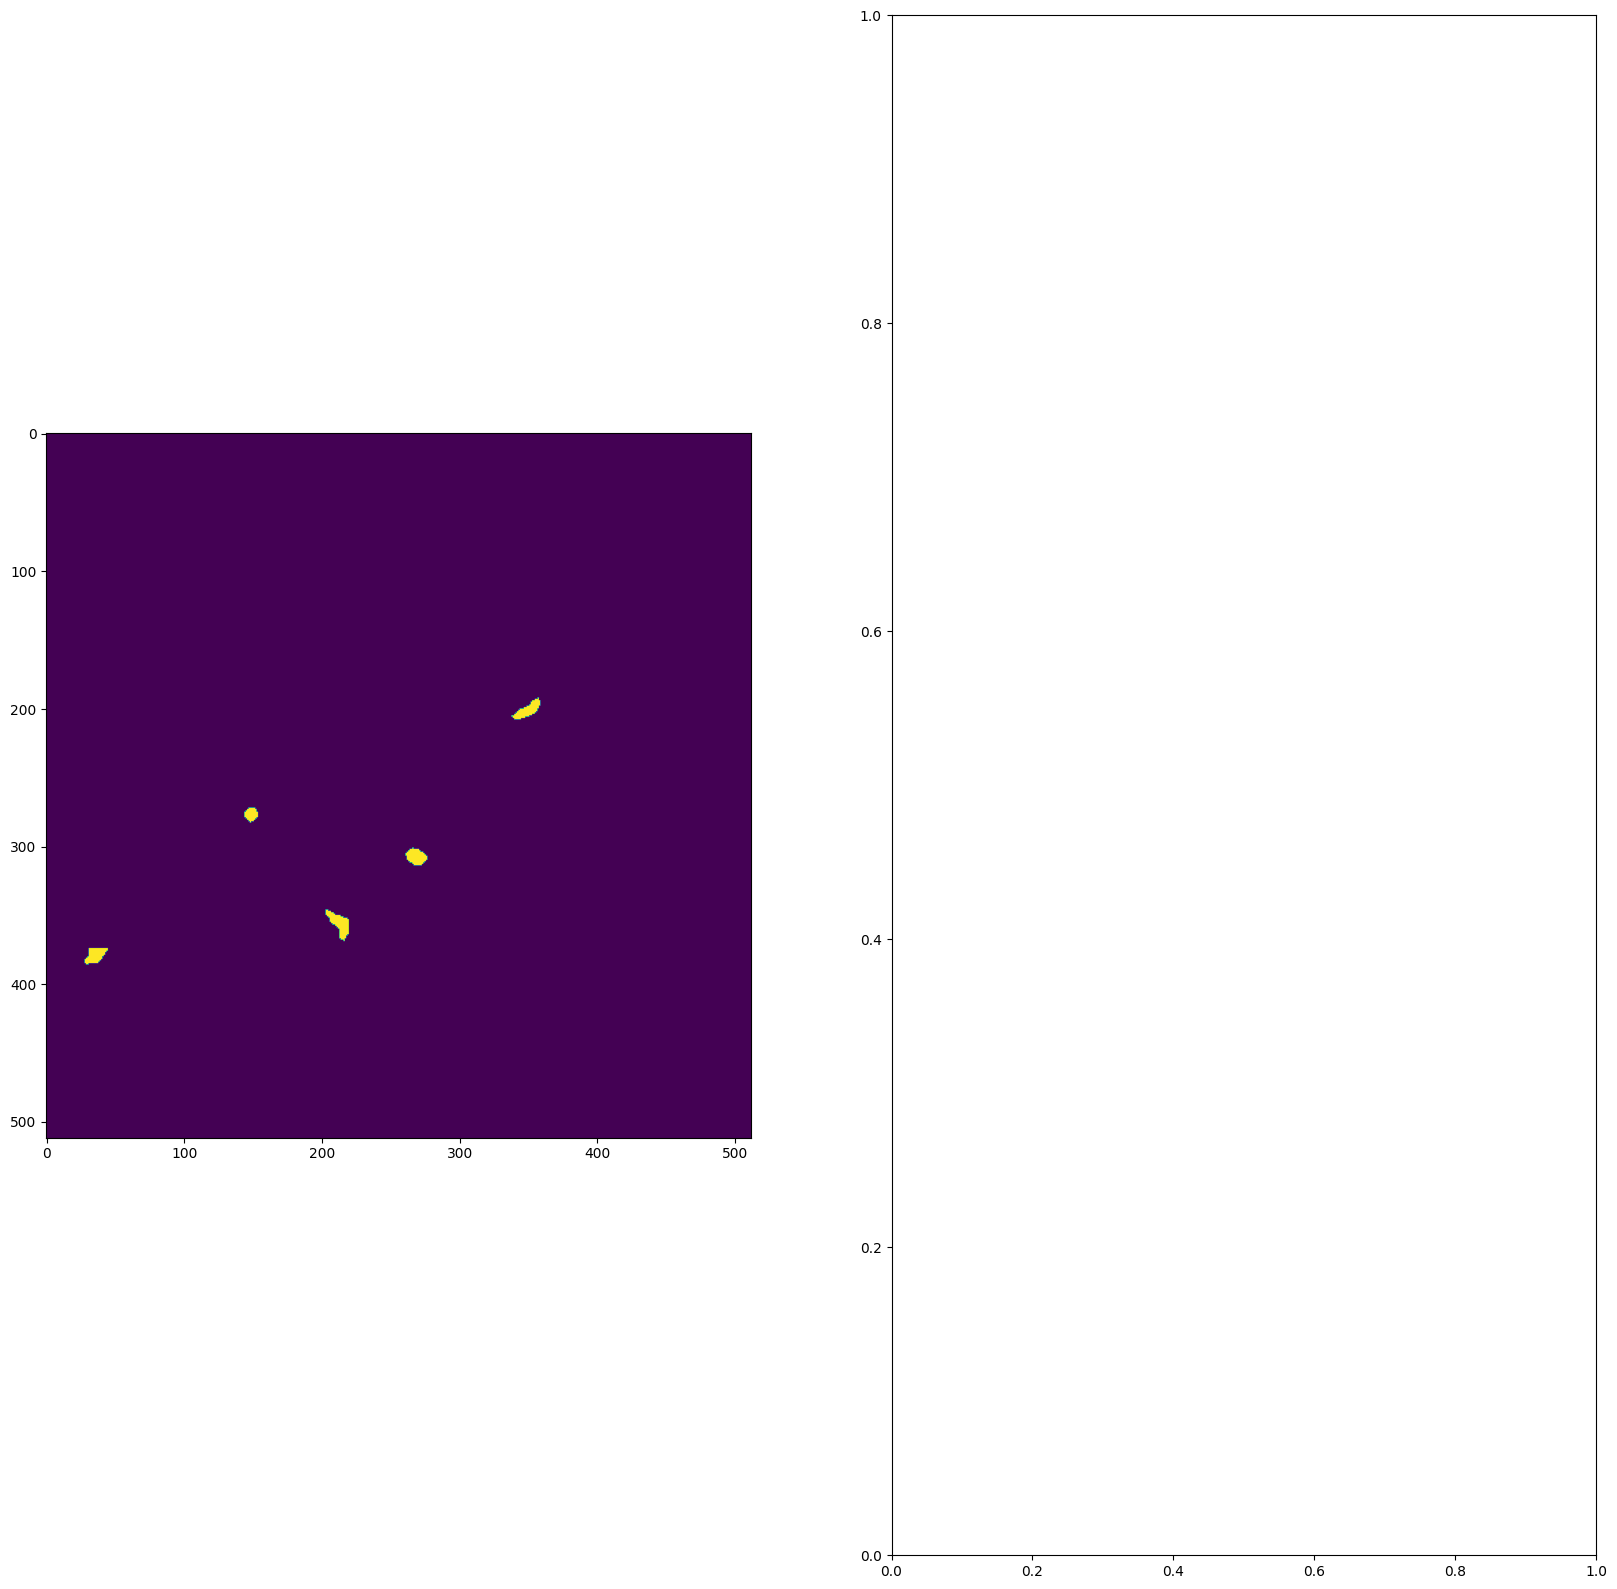

In [166]:
import matplotlib.pyplot as plt
import numpy
t = iter(train_dataloader)
for i in range(5):
    image = next(t)
image = (next(t)["label"][3]/255).permute(1, 2, 0).numpy()
fig, ax = plt.subplots(1, 2, figsize=(20, 20)); ax : list[plt.Axes]
# plt.imshow(np.load(dataset["train"][23]["image"]))
# plt.imshow(np.load(dataset["train"][23]["label"]))
ax[0].imshow(image)

torch.Size([1, 3, 512, 512])


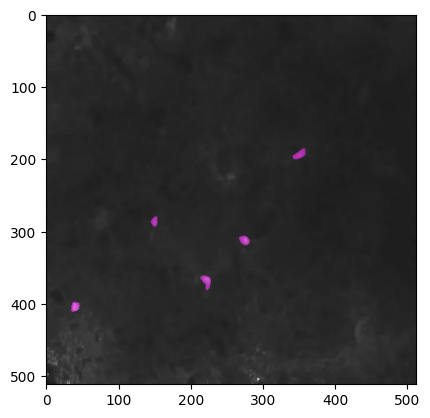

In [197]:
image = torch.randn(1, 3, 512, 512).to(device)
image = torch.tensor(np.load(dataset["train"][23]["image"])).permute(2, 0, 1).unsqueeze(dim=0).to(device).float()
print(image.shape)
outputs = model(image)
mask = (torch.sigmoid(outputs) > 0.9).int()
image = image.squeeze()
colored_mask = torch.zeros_like(image)
colored_mask[0] = mask/2
colored_mask[2] = mask/2

mask = mask.squeeze().cpu().numpy()
image = image.squeeze().permute(1, 2, 0).cpu().numpy()
image = image / 255
mask = mask / mask.max()

colored_mask_np = colored_mask.permute(1, 2, 0).cpu().numpy()
alpha = 1
masked_image = ((image + colored_mask_np * alpha) / (image + colored_mask_np * alpha).max())

masked_image = (masked_image * 255).astype(np.uint8)
masked_image = Image.fromarray(masked_image)
masked_image.save(os.path.join("output", os.path.basename(dataset["train"][23]["image"]) + "_attention_unet.jpg"))

plt.imshow(masked_image)

In [ ]:
        inputs = inputs_list[i][3] / 255
        outputs = outputs_list[i][3]
        outputs = outputs / outputs.max()
        colored_mask = torch.zeros_like(inputs)
        colored_mask[0] = outputs/2  # красный канал
        colored_mask[2] = outputs/2  # красный канал
        
        colored_mask_np = colored_mask.permute(1, 2, 0).cpu().numpy()
    
        inputs = inputs_list[i][0].permute(1, 2, 0).clone().cpu()/255
        masked_image = ((inputs + colored_mask_np * alpha) / (inputs + colored_mask_np * alpha).max())
        targets = targets_list[i][3].squeeze(dim=0).clone().cpu()
        outputs = outputs_list[i][3].squeeze(dim=0).clone().cpu()
        print(masked_image[:,:,1].shape)
        
        ax[i, 0].imshow(inputs)
        ax[i, 1].imshow(targets)
        ax[i, 2].imshow(outputs/outputs.max())
        ax[i, 3].imshow(masked_image)
        image = (masked_image * 255).astype(np.uint8)
        image = Image.fromarray(image)
        image.save(os.path.join("output", os.path.basename(dataset["test"][i]["image"]) + "_attention_unet.jpg"))
        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Target")
        ax[i, 2].set_title("Prediction")
        ax[i, 3].set_title("Maked Prediction")